In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
import torchvision
import os
import random

In [2]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
import sklearn
from sklearn.datasets import fetch_olivetti_faces

# Exercise : Convolution Neural Network

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
# Download data and define the transformer (data normalization)
# Do not change this function
def load_data(seed_value=42):
    MNIST_normalize = transforms.Normalize((0.1307,), (0.3081,))
    MNIST_transform = transforms.Compose([
      transforms.ToTensor(),
      MNIST_normalize
    ])

    # MNIST Dataset
    train = datasets.MNIST(root='./data/',
                                train=True,
                                transform=MNIST_transform,
                                download=True)

    test = datasets.MNIST(root='./data/',
                                train=False,
                                transform=MNIST_transform)

    #print(valid.dataset.data.shape)
    train_subset_size = 5000
    train.data = train.data[0:train_subset_size]
    train.targets = train.targets[0:train_subset_size]

    train_size = int(0.9 * train_subset_size)
    val_size =  int(0.1 * train_subset_size)
    print("train_set_size:", train_size)
    print("val_set_size:", val_size)

    train, valid = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(seed_value))

    return train, valid, test

In [5]:
# Function to show data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# Data Loader 
def get_data_loaders(dataset, batch_size, shuffle=True):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    return loader

In [7]:
# Model
class Conv_Net(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.drop = nn.Dropout(dropout_value)
        self.fc = nn.Linear(6400, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.drop(x)
        x = self.fc(x)
        return F.log_softmax(x)

In [8]:
# Run one training epoch
def train(epoch, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [9]:
# Compute metrics
def test(test_loader, device, is_train_set=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).data
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Train evaluation' if is_train_set else 'Val/Test evaluation', test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
# Use the default seed
seed_everything(seed=42)

# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.0
num_epochs = 15

# Select the device
# device = 'cuda'
device = 'cpu'

# Define the network
model = Conv_Net(dropout_value).to(device)

# Define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

# Divide the available data into training and validation datasets
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)

# Run the training epochs
for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)

# Compute the metrics using the testing dataset
test(test_loader, device, is_train_set=False)

9913344it [00:00, 27714564.02it/s]                             


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



29696it [00:00, 3844023.57it/s]          


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



1649664it [00:00, 17032235.33it/s]         


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



5120it [00:00, ?it/s]                   


Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw

train_set_size: 4500
val_set_size: 500


C:\Users\20201930\AppData\Local\Temp\ipykernel_7636\1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.338832
Train Epoch: 1 [1280/4500 (28%)]	Loss: 3.472326
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.623171
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.983376


c:\Users\20201930\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train evaluation: Average loss: 0.4743, Accuracy: 3901/4500 (87%)


Val/Test evaluation: Average loss: 0.5751, Accuracy: 420/500 (84%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.411269
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.438318
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.404392
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.211955

Train evaluation: Average loss: 0.2938, Accuracy: 4133/4500 (92%)


Val/Test evaluation: Average loss: 0.4201, Accuracy: 432/500 (86%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.358012
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.476700
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.071556
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.219215

Train evaluation: Average loss: 0.2486, Accuracy: 4169/4500 (93%)


Val/Test evaluation: Average loss: 0.4027, Accuracy: 442/500 (88%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.269695
Train Epoch: 4 [1280/4500 (28%)]	Loss: 0.492366
Train Epoch: 4 [2560/4500 (56%)]	Loss: 0.531782
Train Epoch: 4 [3840/4500 (83%)]	Loss: 0.299124

Train evaluation: Averag

KeyboardInterrupt: 

# Exercise : MF Faces

In [ ]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Definition of the data matrix:

In [ ]:
D = faces.data

The observations/rows pf the data matrix can be visualized as pictures. 10 consecutive pictures are taken from one person. This are the first 30 pictutres.

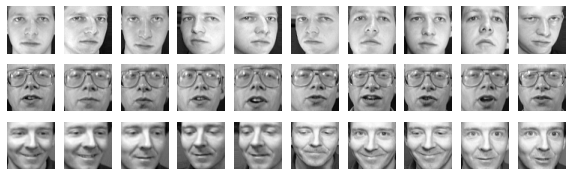

In [ ]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

# Exercise: k-means Initialization

In [ ]:
!pip3 show scikit-learn

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/homebrew/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sklearn


In [ ]:
!pip3 show numpy

Name: numpy
Version: 1.24.1
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /opt/homebrew/lib/python3.9/site-packages
Requires: 
Required-by: matplotlib, pandas, scikit-learn, scipy, seaborn, tensorboard, torchvision


If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [ ]:
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

The functions generating the datasets are given here:

In [ ]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 2.5, epsilon + 0.5])
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [ ]:
def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    return X

In [ ]:
import scipy
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")
    A = V[:,1:]
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)
    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [ ]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [ ]:
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

We generate a dataset.

In [ ]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

Run kmeans and spectral clustering based on the initialization technique.

In [ ]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

6 iterations


Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

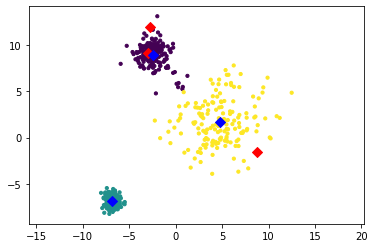

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [ ]:
dataID, D, labels, r = generateMoons(0.05,n)

4 iterations


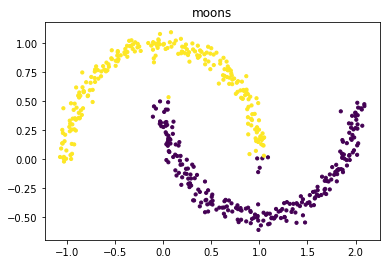

In [ ]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = radius_neighbors_graph(D,0.5,include_self=False)
Y = spectral_clustering(W,r,init_centroids_greedy_pp)

plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()

# Exercise : Movielens
To read the dataset you might need to alter the path to look for it:

In [ ]:
# lets explore movies.csv
movies= pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# lets explore ratings.CSV
ratings=pd.read_csv('ml-latest-small/ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The original ratings are in the range of 0.5 and 5:

In [ ]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [ ]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 200 users. That are 18 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the prnciple and do not need a big dataset.

In [ ]:
np.sum(np.sum(df_movie_ratings!=0,0)>200)

18

In [ ]:
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have not rated more than five movies.

In [ ]:
np.sum(np.sum(df_D!=0,1)>5)

344

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [ ]:
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,1.0,5.0,4.0,0.0,2.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
7,4.5,0.0,4.5,0.0,4.5,5.0,0.0,0.0,5.0,5.0,0.0,2.5,5.0,4.5,4.0,0.0,4.0,0.0


The movie number- title assignments are given as follows:

In [ ]:
movies.loc[movies['movieId'].isin(df_D.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


The resulting data matrix is given as follows:

In [ ]:
D = df_D.to_numpy()
D.shape